<a href="https://colab.research.google.com/github/Utree/deeplearning2_colab_log/blob/master/2%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

単語の意味

コンピュータに単語の意味を理解させるには
- シソーラスによる手法
- カウントベースの手法
- 推論ベースの方法(word2vec)

# シソーラス
シソーラスとは、類語辞典で、「同じ意味の単語(同義語)」や「似た意味の単語(類義語)」が同じグループに存在する

シソーラスでは、「上位と下位」「全体と部分」などの細かい関係性が定義されている場合があり、単語間のつながりである「単語ネットワーク」を利用することで、コンピュータに単語の意味を授けることができる

自然言語処理の分野において、最も有名なシソーラスは**WordNet**で、類義語の取得、類似度の算出ができる。

シソーラスの問題点
- 時代の変化に対応するのが、困難
- 人の作業コストが高い
- 単語の細かなニュアンスを表現できない

# カウントベースによる手法



# コーパス
コーパスとは、目的を持って収集された、大量のテキストデータ

In [0]:
text = 'You say goodbye and I say hello.'

In [2]:
text = text.lower() # 小文字に変換
text = text.replace('.', ' .') # .を .に変換
text

'you say goodbye and i say hello .'

In [3]:
words = text.split(' ') # スペースを区切り文字として分割
words # 文を単語のリストとして、保存

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [0]:
word_to_id = {}
id_to_word = {}

# 単語にidを振って、IDのリストとして利用できるように変更を加える
for word in words:
  if word not in  word_to_id:
    new_id = len(word_to_id)
    word_to_id[word] = new_id
    id_to_word[new_id] = word

In [5]:
id_to_word # idから単語を検索できる

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [6]:
word_to_id # 単語からidを検索できる

{'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0}

In [7]:
id_to_word[1]

'say'

In [8]:
word_to_id['hello']

5

In [9]:
import numpy as np
# words: 単語のリストを word_to_id: 単語IDのリストに変換
corpus = [word_to_id[w] for w in words]
# word_to_id: 単語IDのリストを corpus: numpy配列に変換
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [0]:
def preprocess(text):
  '''
    文字列を前処理して、単語リストを出力する
  '''
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')
  
  word_to_id = {}
  id_to_word = {}
  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word
  
  corpus = np.array([word_to_id[w] for w in words])
  
  return corpus, word_to_id, id_to_word

# 単語の分散表現

単語の意味をベクトル表記したもの

# 分布仮説
単語の意味は周囲の単語によって形成される

## コンテキスト

周囲に存在する単語

## 共起行列



In [11]:
import numpy as np

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [0]:
# 共起行列
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

In [13]:
print(C[0]) # 単語IDが0のベクトル

[0 1 0 0 0 0 0]


In [14]:
print(C[4]) # 単語IDが4のベクトル

[0 1 0 1 0 0 0]


In [15]:
print(C[word_to_id['goodbye']]) # "goodbye"のベクトル

[0 1 0 1 0 0 0]


In [0]:
def create_co_matrix(corpus, vocab_size, window_size=1):
  '''
    コーパスから共起行列をつくる関数
  '''
  
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
  
  for idx, word_id in enumerate(corpus):
    for i in range(1, window_size + 1):
      left_idx = idx - i
      right_idx = idx + i
      
      if left_idx >= 0:
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1
      
      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1
  
  return co_matrix

## コサイン類似度

2つのベクトルがあるとき、どれだけ同じ方向を見いているかを1から-1の間の数字で表す

全く同じ時、コサイン類似度は1

完全に逆向きだと、-1になる

In [0]:
def cos_similarity(x, y):
  '''
    コサイン類似度を算出する
  '''
  nx = x / np.sqrt(np.sum(x**2)) # xの正規化
  ny = y / np.sqrt(np.sum(y**2)) # yの正規化
  return np.dot(nx, ny)

0ベクトルが引数に入ると0除算が発生してしまうので、esp=1e-8を加算して、対処

In [0]:
def cos_similarity(x, y, eps=1e-8):
  '''
    コサイン類似度を算出する(改良版)
  '''
  nx = x / (np.sqrt(np.sum(x**2)) + eps)
  ny = y / (np.sqrt(np.sum(y**2)) + eps)
  return np.dot(nx, ny)

In [19]:
text  = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # "you"の単語ベクトル
c1 = C[word_to_id['i']] # "i"の単語ベクトル
print(cos_similarity(c0, c1))

0.7071067691154799


In [0]:
# 類似単語のランキングを表示
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
  '''
    引数
    
    query: クエリ(単語)
    word_to_id: 単語から単語IDへのディクショナリ
    id_to_word: 単語IDから単語へのディクショナリ
    word_matrix: 単語ベクトルをまとめた行列
    top: 上位何位まで表示するか
  '''
  
  # クエリを取り出す
  if query not in word_to_id:
    print('%s is not found' % query)
    return
  
  print('\n[query] ' + query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]
  
  # コサイン類似度の算出
  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size)
  for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
  # コサイン類似度の結果からその値を高い順に出力
  count = 0
  for i in (-1 * similarity).argsort(): # argsort関数で、インデックスを要素の小さい順にソートし、インデックス番号を返す
    if id_to_word[i] == query:
      continue
    print(' %s: %s' % (id_to_word[i], similarity[i]))
    
    count += 1
    if count >= top:
      return

In [22]:
# argsort

x = np.array([100, -20, 2])
x.argsort()

array([1, 2, 0])

In [23]:
(-x).argsort()

array([0, 2, 1])

In [24]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 相互情報量(PMI)

単語間の共起を考えるときに、単なる出現回数を数えると"the"のような高頻度単語に強い関連性が現れてしまう。

そこで、単独での出現回数と、共起回数の確率を考慮したPMIという指標を用いる

共起回数０の場合-∞になってしまうことを考慮して、実践上は**正の相互情報量(Positive PMI)**を用いる

In [0]:
def ppmi(C, verbose=False, eps=1e-8):
  '''
    共起行列をPPMI行列に変換する関数
  '''
  M = np.zeros_like(C, dtype=np.float32)
  N = np.sum(C)
  S = np.sum(C, axis=0)
  total = C.shape[0] * C.shape[1]
  cnt = 0
  
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(C[i, j]*N / (S[j]*S[i]) + eps)
      M[i, j] = max(0, pmi)
      
      if verbose:
        cnt += 1
        if cnt % (total//100) == 0:
          print('%.1f%% done' % (100*cnt/total))
  return M

In [27]:
import numpy as np
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) # 有効桁3桁で表示
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


PPMI行列は、単語数が増えると、ベクトルの次元数も増える。

行列の中身を見てみると0が多い。つまり、重要でない要素が多い

このようなベクトルは、ノイズに弱い。


ここで用いられる対処法が、ベクトルの次元削減(dimensionality reduction)

次元削減を行う方法の一つとして、特異値分解(Singular Value Decomposition: SVD)がある。

SVDでは、任意の行列XをUSVの３つの行列に分解する

また、UとVは直交行列で、列ベクトルはお互いに直行する

Sは対角行列で、対角成分以外はすべて0の行列

## 直交行列
転置行列と逆行列が等しくなる正方行列

## 転置行列

![転置行列](https://techblog.nhn-techorus.com/wp-content/uploads/2015/12/matrix3_6.1.png)

## 逆行列

![逆行列](https://atarimae.biz/wp-content/uploads/2018/06/inverse-2-2.png)

## 対角行列

対角成分以外はすべて0の行列

In [0]:
import numpy as np
import matplotlib.pyplot as plt

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W) # linalg(linear algebra: 線形代数)

In [32]:
print(C[0]) # 共起行列

[0 1 0 0 0 0 0]


In [33]:
print(W[0]) # PPMI行列

[0.    1.807 0.    0.    0.    0.    0.   ]


In [34]:
print(U[0]) # SVD

[ 3.409e-01  0.000e+00 -1.205e-01 -3.886e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


共起行列: C[]がPPMI行列W[]に変換され、SVDによって、密なベクトルU[]に変換されている。

In [36]:
print(U[0, :2])

[0.341 0.   ]


この密なベクトルを次元削減するには、単に、先頭の２つの要素を取り出す

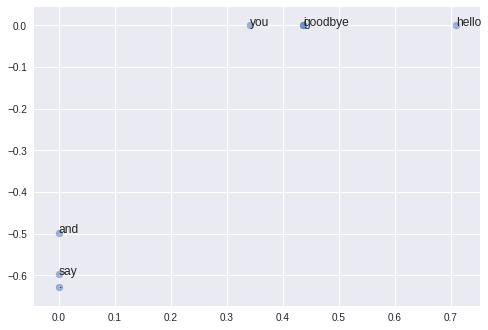

In [35]:
# 2次元のベクトルで表し、グラフにプロット
for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1])) # annotate(word, x, y)でx, y地点にwordを描画
  
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

In [40]:
# PTBデータセットをインポート
import sys
import os
sys.path.append('..')
import urllib.request
import pickle
import numpy as np

url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

dataset_dir = os.path.dirname(os.path.abspath('__file__'))


def _download(file_name):
    file_path = dataset_dir + '/' + file_name
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')


def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word


def load_data(data_type='train'):
    '''
        :param data_type: データの種類：'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val': data_type = 'valid'
    save_path = dataset_dir + '/' + save_file[data_type]

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name
    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word


if __name__ == '__main__':
    for data_type in ('train', 'val', 'test'):
        load_data(data_type)

Done
Done
Done


In [42]:
corpus, word_to_id, id_to_word = load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']", word_to_id['happy'])
print("word_to_id['lexus']", word_to_id['lexus'])

corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy'] 4428
word_to_id['lexus'] 7426


In [44]:
window_size = 2
wordvec_size = 100
corpus, word_to_id, id_to_word = load_data('train')
vocab_size = len(word_to_id)
print('counting co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
  # truncated SVD (fast!)
  from sklearn.utils.extmath import randomized_svd
  U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
  # SVD (slow)
  U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting co-occurrence ...
calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0